# Построние логарифмических спиралей по Buchin et.al.
1. Ограничения угла (*angle restriction*)
2. Построение одиночной спирали
3. Построение одиночной спирали между двумя точками
4. Поиск пересечения двух спиралей

In [14]:
# Импорты
from sympy import solve, cos, sin, exp, plot_parametric, symbols, rad
from sympy.geometry import Curve
import math
import numpy as np

ModuleNotFoundError: No module named 'sympy'

### 1. Ограничения угла
Под ограничением угла в точке *p* понимается ограничение максимального значения угла между вектором (*p*, *корень*) и касательным вектором к кривой в точке *p*.

### 2. Построение одиночной спирали

In [ ]:
b = 1
b2 = 1
a = 1
a2 = 1

t = symbols("t")
x = (a*exp(b*t))*cos(t)
x2 = (a2*exp(b2*t))*cos(t) + 1000
y = (a*exp(b*t))*sin(t)
y2 = (a2*exp(b2*t))*sin(t)
plot_parametric((x, y, (t, 0, 10)), (x2, y2, (t, 0, 10)), size=(5,5))

In [ ]:
curve1 = Curve((x, y), (t, 0,10))
curve2 = Curve((x2, y2), (t, 0,10))

### 3. Актуальная реализация

In [1]:
import numpy as np
import math, copy
from matplotlib import pyplot as plt
from shapely.geometry import LineString

def euclidian_dst(a, b):
    if not (type(a) == type(b) and np.array(a).shape == np.array(b).shape and np.array(a).shape == (2,)):
        raise ValueError("a, b has to be sequences with shape (1, 2)")
    
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def rl_inverse(key):
    assert key in ('right', 'left'), "must be 'right' or 'left'"
    if key =='right':
        return 'left'
    else:
        return 'right'

In [2]:
class ShiftedLogCurve(): 

    def __init__(self, a=1, b=1, root=(0,0), leaf=(0,20), vbs = False, run=False):
        '''
        КОНСТРУКТОР
        Инициализирует параметры кривой. Переводит координаты корня и листа в полярные координаты
        a: радиус кривизны
        b: производная
        root: координаты корня
        leaf: координаты листа
        vbs: verbose output? True/False
        run: Если True, запускаются функции eval и кривая строится после инициализации (определяются координаты точек)
        
        self.th: область определения функции (диапазон параметра t)
        '''
        self.a = a # Радиус кривизны
        self.b = b # Производная
        self.th = np.linspace(0, np.pi, 100) # Область определения в полярных координатах (угол в радианах)
        self.root = root # Координаты корня
        self.leaf = leaf # Координаты листа
        self.vbs = vbs # verbose?
        self.run = run # run?
        self.ang = None # Дирекционный угол в радианах (против часовой стрелки от оси x)
        self.dst = None # Расстояние между корнем и листом

        self._pts_to_polar()
        
        self.crds = None # Прямоугольные координаты
        self.r = None # Массив r(th) радиусов в полярных координатах
        if run:
            self.eval_a()
            self._eval_r(self.th)
            self.proj_rect()
        
    
    def _pts_to_polar(self):
        '''
        ПЕРЕВОД В ПОЛЯРНЫЕ КООРДИНАТЫ (0° вправо, отсчёт против часовой стрелки)
        Для построения кривой между корнем и листом необходимо подобрать параметр a при фиксированном b.
        Для этого в данной реализации необходимо знать расстояние от корня до листа.
        Азимут нужен для обратного перевода кривой в прямоугольные координаты
        
        формат координат: (ось абсцисс, ось ординат)
        
        return не предусмотрен.
        Модифицируются:
        self.ang: азимут
        self.dst: расстояние
        '''
        dx = self.leaf[0] - self.root[0]
        dy = self.leaf[1] - self.root[1]
        if self.vbs: print("dx: ", dx, "dy: ", dy)
        try:
            self.ang = np.arctan2(dy, dx)
        except ZeroDivisionError:
            self.ang = -np.pi/2 # Ловим деление на 0 при dx = 0
        if self.vbs: print("angle: ", np.degrees(self.ang))
        self.dst = np.sqrt(dx**2 + dy**2)
        if self.vbs: print("distance: ", self.dst)
    
    def _eval_r(self, th):
        '''
        ОПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ РАДИУСА ДЛЯ ОБЛАСТИ ОПРЕДЕЛЕНИЙ (углов)
        Экспонента сдвинута на -1.
        Таким образом область значений сдвигается на -self.a относительно лог. спирали по определению
        Это необходио, чтобы область значений начиналась от 0
        th: np.array область определения (массив углов для котрых требуется рассчитать радиус)
        
        return: np.array значения функции в полярных координатах
        '''
        self.r = self.a*(np.exp(self.b*th)-1)
        return self.a*(np.exp(self.b*th)-1)
    
    def proj_rect(self, r=None):
        '''
        ПЕРЕВОД В ПРЯМОУГОЛЬНЫЕ КООРДИНАТЫ
        Функция переводит кривую в полярных координатах (массив R(th) для массива th) в прямоугольные (массив x и массив y)
        Результат: редактирование атрибута self.crds

        input: обязательных аргументов нет
        R: массив R(th). Если None, то используется self.R

        return: self.crds (на всякий случай)
        '''
        if r is None:
            r = self.r
        thr = self.th + self.ang + np.pi
        thl = -self.th + self.ang + np.pi
        xr = r*np.cos(thr)
        yr = r*np.sin(thr)
        xl = r*np.cos(thl)
        yl = r*np.sin(thl)
        self.crds = {"right_xy": [xr, yr], "left_xy": [xl, yl]}
        return self.crds
    
    def eval_r(self, th=None, run=False):
        '''
        ОПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ РАДИУСА ДЛЯ ОБЛАСТИ ОПРЕДЕЛЕНИЙ (углов)
        Функция вызова
        Вызывает _eval_r с заданной областью определения (th).
        Если область не задана, используется инициализированная ([0, np.pi])
        
        th: np.array
        run: Если True, то объект подлежит изменению. Если False, то объект не будет изменён

        return: np.array значения функции в полярных координатах
        
        '''
        if (th is None) and run:
            return self._eval_r(self.th)
        elif not(th is None) and run:
            return self._eval_r(th)
        elif th is None:
            return self.a*(np.exp(self.b*self.th)-1)
        else:
            return self.a*(np.exp(self.b*th)-1)

    def eval_a(self):
        '''
        РАСЧЁТ self.a
        Рассчитывает параметр a, который нужно использовать, чтобы "вписать" кривую с заданным b
        между корнем и листом
        Экспонента сдвинута на -1
        
        Входных параметров и return не предусмотрено
        '''
        self.a = self.dst/(np.exp(self.b*np.pi)-1)
    
    def draw(self):
        # Отрисовка кривой внутри области определения
        fig = plt.figure(1,(15,15))
        ax1 = fig.add_subplot(221,polar=True) # раскомментировать эту строку и "222" для отображения в полярных координатах
        ax2 = fig.add_subplot(222,polar=False)
        
        xr,yr = self.proj_rect()["right_xy"]
        xl,yl = self.proj_rect()["left_xy"]
        ax1.plot(self.th, self.r, "-c")
        ax1.plot(-self.th, self.r, "-m")
        ax2.plot(xr,yr, "-c")
        ax2.plot(xl,yl, "-m")
        ax2.plot(self.leaf[0], self.leaf[1], "og")
        ax2.plot(self.root[0], self.root[1], "sg")
        ax2.set_aspect(1)
    
    # Геттеры

    def get_polar(self, tp="right"):
        """
        tp = "right"/"left" (тип спирали: правая или левая)
        """
        if tp == "right":
            return (self.th, self.r)
        elif tp == "left":
            return (-self.th, self.r)
        else:
            raise ValueError('tp has to be "right" or "left"')
    
    def get_rect(self, tp="right"):
        """
        tp = "right"/"left" (тип спирали: правая или левая)
        """
        if tp in ("right", "left"):
            return (self.crds[f"{tp}_xy"][0], self.crds[f"{tp}_xy"][1])
        else:
            raise ValueError('tp has to be "right" or "left"')

            

In [3]:
class LimitedSLC(ShiftedLogCurve):
    '''
    Дополнительные атрибуты:
    tp - тип. Принимает значения 'right' и 'left'
    upperlimit_xy - координаты верхней границы
    lowerlimit_xy - координаты нижней границы

    
    '''
    def draw(self):
        # Отрисовка кривой внутри области определения
        fig = plt.figure(1,(15,15))
        ax1 = fig.add_subplot(221,polar=True) # раскомментировать эту строку и "222" для отображения в полярных координатах
        ax2 = fig.add_subplot(222,polar=False)
        
        x,y = self.proj_rect()[f"{self.tp}_xy"]
        
        if self.tp == 'right':
            sign = -1
            color = 'c'
        else:
            sign =1
            color = 'm'

        ax1.plot(self.th*sign, self.r, f"-{color}")
        
        ax2.plot(x,y, f"-{color}")


        ax2.plot(self.lowerlimit_xy[0], self.lowerlimit_xy[1], "^k")
        ax2.plot(self.upperlimit_xy[0], self.upperlimit_xy[1], "vk")

        ax2.plot(self.leaf[0], self.leaf[1], "og")
        ax2.plot(self.root[0], self.root[1], "sg")

        ax2.set_aspect(1)
    
    def batch_draw(self, ax1, ax2):
        # Добавление кривой на передаваемый график
        
        x,y = self.proj_rect()[f"{self.tp}_xy"]
        
        if self.tp == 'right':
            sign = -1
            color = 'c'
        else:
            sign =1
            color = 'm'

        ax1.plot(self.th*sign, self.r, f"-{color}")
        
        ax2.plot(x,y, f"-{color}")
        ax2.plot(self.lowerlimit_xy[0], self.lowerlimit_xy[1], "^k")
        ax2.plot(self.upperlimit_xy[0], self.upperlimit_xy[1], "vk")
        ax2.plot(self.leaf[0], self.leaf[1], "og")
        ax2.plot(self.root[0], self.root[1], "sg")
        ax2.set_aspect(1)
    

    def crop(self, tp, upperlimit_xy=None, lowerlimit_xy=None):
        '''
        Вырезание кривой между точками
        '''
        # Проверки и определения
        assert tp in ('right', 'left'), "tp must be assigned"

        self.tp = tp
        self.upperlimit_xy = upperlimit_xy
        self.lowerlimit_xy = lowerlimit_xy

        upperlimit_th = lowerlimit_th = None

        if upperlimit_xy is None:
            self.upperlimit_xy = self.leaf
            upperlimit_th = np.pi
        if lowerlimit_xy is None:
            self.lowerlimit_xy = self.root
            lowerlimit_th = 0
        
        # Расчет
        if tp == 'right': sign = -1
        else: sign =1

        if upperlimit_th is None:
            upperlimit_th = np.pi + self.ang*sign - np.arctan2(upperlimit_xy[1]-self.root[1], upperlimit_xy[0]-self.root[0])
        if lowerlimit_th is None:
            lowerlimit_th = np.pi + self.ang*sign - np.arctan2(lowerlimit_xy[1]-self.root[1], lowerlimit_xy[0]-self.root[0])

        # Запись результата
        self.th = np.linspace(lowerlimit_th, upperlimit_th, 100)
        # Перевычисление радиусов для новых th
        self.eval_r(run=True)
        
    def get_dst2(self):
        try:
            return np.sqrt((self.upperlimit_xy[0]-self.lowerlimit_xy[0])**2 + (self.upperlimit_xy[1]-self.lowerlimit_xy[1])**2)
        except AttributeError:
            return self.dst

In [4]:
def intersect(curve1, curve2, plotting=False):
    '''
    Эта функция представляет собой костыль, состоящий из костылей. это всё, что о ней надо знать.
    Она возвращает координату самого удалённого от корня пересечения границ двух спиральных областей.
    Иногда возвращает None. В каких именно случаях, неясно
    '''
    assert curve1.root == curve2.root, "Roots have to be the same" 
    assert curve1.leaf != curve2.leaf, "Leaves must not be the same (we assume that a, b, th of curves are equal"
    # print("first pair")
    first_line = LineString(np.column_stack((curve1.crds["right_xy"][0], curve1.crds["right_xy"][1])))
    second_line = LineString(np.column_stack((curve2.crds["left_xy"][0], curve2.crds["left_xy"][1])))
    intersection = first_line.intersection(second_line)
    # print(intersection.geom_type)
    try:
        inter_crds0 = np.array(LineString(intersection).coords.xy)
        inter_crds0 = inter_crds0[inter_crds0 != curve1.root]
        # print(inter_crds0.shape, "\n", inter_crds0)
        # inter_crds = inter_crds[inter_crds != 0]
    
        dst0 = np.sqrt((inter_crds0[0]-curve1.root[0])**2 + (inter_crds0[1]-curve1.root[1])**2)

        # plt.plot(inter_crds0[0], inter_crds0[1], 'or')
    except AssertionError:
        inter_crds0 = (None,None)
        dst0 = float('inf')

    # print("second pair")
    first_line = LineString(np.column_stack((curve1.crds["left_xy"][0], curve1.crds["left_xy"][1])))
    second_line = LineString(np.column_stack((curve2.crds["right_xy"][0], curve2.crds["right_xy"][1])))
    intersection = first_line.intersection(second_line)
    # print(intersection.geom_type)
    try:
        inter_crds1 = np.array(LineString(intersection).coords.xy)
        inter_crds1 = inter_crds1[inter_crds1 != curve1.root]
        # print(inter_crds1.shape, "\n", inter_crds1)

        dst1 = np.sqrt((inter_crds1[0]-curve1.root[0])**2 + (inter_crds1[1]-curve1.root[1])**2)

        # plt.plot(inter_crds0[0], inter_crds0[1], 'or') 
    except AssertionError:
        inter_crds1 = (None,None)
        dst1 = float('inf')
    
    if (dst0 >= dst1) and dst0 != float('inf'):
        if plotting: plt.plot(inter_crds0[0], inter_crds0[1], 'or')
        return {'curves': (curve1, curve2), 'position_type': (inter_crds0, "right"), 'dst': dst0}
    elif (dst1 >= dst0) and dst1 != float('inf'):
        if plotting: plt.plot(inter_crds1[0], inter_crds1[1], 'or')
        return {'curves': (curve1, curve2), 'position_type': (inter_crds1, "left"), 'dst': dst1}

    if all(inter_crds0) == None:
        if all(inter_crds1.all) == None:
            return None
        else:
            return {'curves': (curve1, curve2), 'position_type': (inter_crds1, "left"), 'dst': dst1}
    else:
        return {'curves': (curve1, curve2), 'position_type': (inter_crds0, "right"), 'dst': dst0}

In [19]:
class FlowTreeBuilder():

    def __init__(self, root=(0,0), leaves=[ (17, -4), (20, 7), (-10, 15), (-5, 20), (-8, -20) ], b=1.9):
        self.root = root
        self.leaves = leaves
        self.b = b
        self.main_exec()
    
    def main_exec(self):
        res_curves = []
        before_parts = []
        self.curves = []
        self.init_curves_dsts_dict = {}
        for i in self.leaves:
            curve = LimitedSLC(b=self.b, root=self.root, leaf=i, run=True)
            self.curves.append(curve)
            self.init_curves_dsts_dict[curve] = curve.get_dst2()
        sorted_tuples = sorted(self.init_curves_dsts_dict.items(), key=lambda item: item[1], reverse=True)
        self.init_curves_dsts_dict = {k: v for k, v in sorted_tuples}

        draw(self.curves)

        init_curves = list(self.init_curves_dsts_dict.keys())
        dsts = list(self.init_curves_dsts_dict.values())
        print(init_curves,"\n", dsts)

        i=0
        cur_ridge_pos = dsts[i]

        intersects = []
        
        while cur_ridge_pos != 0:
            print('cur_ridge_pos:', cur_ridge_pos)
            active_curves_list = list(np.array(init_curves)[dsts >= cur_ridge_pos])
            for it in before_parts:
                if it.get_dst2() >= cur_ridge_pos:
                    active_curves_list.append(it)
            active_curves_list = sorted(active_curves_list, key=lambda item: item.get_dst2(), reverse=True)
            print('active_curves_list:', active_curves_list)
            for it1 in active_curves_list:
                it2 = active_curves_list.copy()
                it2.remove(it1)
                for it3 in it2:
                    ist = intersect( it1, it3, plotting=False)
                    print('ist:', ist)
                    intersects.append(ist)
            
            intersects_sorted = sorted(intersects, key=lambda item: list(item.values())[2], reverse=True)
            for intersection in intersects_sorted:
                print("##############\n", 'вход в цикл', "\n##############\n")
                print('intersection dst:', intersection['dst'])
                if intersection['dst'] >= cur_ridge_pos:
                    if intersection['curves'][0].dst >= intersection['curves'][1].dst:
                        before_part = copy.copy(intersection['curves'][0]) # сохраняем часть кривой до точки пересечения
                        intersection['curves'][0].crop(tp=intersection['position_type'][1], lowerlimit_xy=intersection['position_type'][0])
                        before_part.crop(tp=intersection['position_type'][1], upperlimit_xy=intersection['position_type'][0])
                        before_parts.append(before_part)
                        intersection['curves'][1].crop(tp=rl_inverse(intersection['position_type'][1]), lowerlimit_xy=intersection['position_type'][0])
                        init_curves.remove(intersection['curves'][0])
                        init_curves.remove(intersection['curves'][1])
                        init_curves.append(before_part)
                        dsts.remove(intersection['curves'][0].dst)
                        dsts.remove(intersection['curves'][1].dst)
                        dsts.append(before_part.get_dst2)
                    else:
                        before_part = copy.copy(intersection['curves'][1]) # сохраняем часть кривой до точки пересечения
                        intersection['curves'][1].crop(tp=intersection['position_type'][1], lowerlimit_xy=intersection['position_type'][0])
                        before_part.crop(tp=intersection['position_type'][1], upperlimit_xy=intersection['position_type'][0])
                        before_parts.append(before_part)
                        intersection['curves'][0].crop(tp=rl_inverse(intersection['position_type'][1]), lowerlimit_xy=intersection['position_type'][0])
                        init_curves.remove(intersection['curves'][0])
                        init_curves.remove(intersection['curves'][1])
                        init_curves.append(before_part)
                        dsts.remove(intersection['curves'][0].dst)
                        dsts.remove(intersection['curves'][1].dst)
                        dsts.append(before_part.get_dst2)
            print("##############\n", before_parts, "\n##############\n")
            try:
                step = dsts[i] - dsts[i+1]
            except IndexError:
                break
            i+=1
            cur_ridge_pos -= step


        #print(intersects)


[<__main__.LimitedSLC object at 0x000001FDDFB5FCD0>, <__main__.LimitedSLC object at 0x000001FDDBBBDA60>, <__main__.LimitedSLC object at 0x000001FDDFB5FD00>, <__main__.LimitedSLC object at 0x000001FDDBBBDF10>, <__main__.LimitedSLC object at 0x000001FDDBBBD460>] 
 [21.540659228538015, 21.18962010041709, 20.615528128088304, 18.027756377319946, 17.46424919657298]
cur_ridge_pos: 21.540659228538015
active_curves_list: [<__main__.LimitedSLC object at 0x000001FDDFB5FCD0>]
##############
 [] 
##############

cur_ridge_pos: 21.18962010041709
active_curves_list: [<__main__.LimitedSLC object at 0x000001FDDFB5FCD0>, <__main__.LimitedSLC object at 0x000001FDDBBBDA60>]
ist: {'curves': (<__main__.LimitedSLC object at 0x000001FDDFB5FCD0>, <__main__.LimitedSLC object at 0x000001FDDBBBDA60>), 'position_type': (array([ 1.65379686, -1.71353209]), 'left'), 'dst': 2.381435760200411}
ist: {'curves': (<__main__.LimitedSLC object at 0x000001FDDBBBDA60>, <__main__.LimitedSLC object at 0x000001FDDFB5FCD0>), 'posi

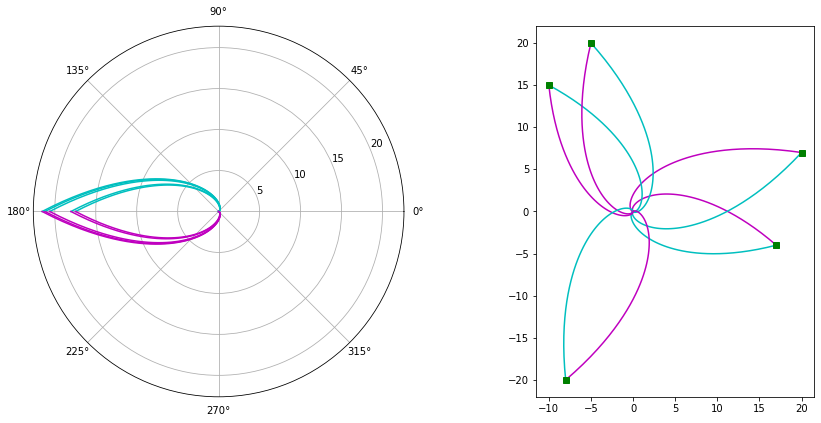

In [ ]:
expl = FlowTreeBuilder()

In [ ]:
class A():

    def __init__(self):
        self.n = np.random.randint(43)
    
    def get_n(self):
        return self.n

In [ ]:
c.n

13

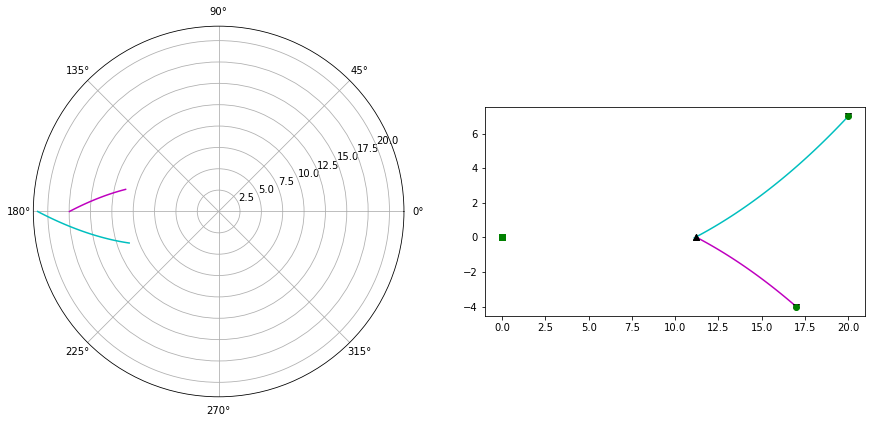

In [5]:
# тест работы LimitedSLC
fig = plt.figure(1,(15,15))
ax1 = fig.add_subplot(221,polar=True)
ax2 = fig.add_subplot(222,polar=False)

b=1.9
curve = LimitedSLC(b=b, root=(0,0), leaf=(17, -4), run=True)
curve1 = LimitedSLC(b=b, root=(0,0), leaf=(20, 7), run=True)
lowlim = intersect(curve, curve1)['position_type'][0]
curve.crop('left',lowerlimit_xy=lowlim)
curve1.crop('right',lowerlimit_xy=lowlim)

curve.batch_draw(ax1, ax2)
curve1.batch_draw(ax1, ax2)


In [ ]:
def draw(curves):
        '''
        аналог ShiftedLogCurve.draw(). Не аналогична LimitedSLC.draw()
        Требует массива объектов.

        В текущем виде бесполезна после появления batch_draw

        curves: массив кривых, инициализированных при run=True
        '''

        fig = plt.figure(1,(15,15))
        ax1 = fig.add_subplot(221,polar=True) # раскомментировать эту строку и "222" для отображения в полярных координатах
        ax2 = fig.add_subplot(
            222,
            polar=False)
        
        for curve in curves:
            # Закомментированы артефакты старых реализаций. Текущая подразумевает, что при инициализации кривой run=True
            # скорее всего если раскомментить их, то ничего не заработает
            
            # curve.eval_a()

            # Отрисовка кривой внутри области определения
            # arr = curve.eval_r()
            # arr2 = self.eval_r(-self.th)

            # Отрисовка в прямоугольных координатах предполагает, что линия корень-лист параллельна оси абсцисс
            # x = arr*np.cos(self.th)
            # y = arr*np.sin(self.th)

            # Отрисовка учитывает координаты root и leaf
            xr,yr = curve.proj_rect()["right_xy"]
            xl,yl = curve.proj_rect()["left_xy"]

            ax1.plot(curve.th, curve.r, "-c")
            ax1.plot(-curve.th, curve.r, "-m")
            ax2.plot(xr,yr, "-c")
            ax2.plot(xl,yl, "-m")
            ax2.plot(curve.leaf[0], curve.leaf[1], "sg")
            ax2.set_aspect(1)

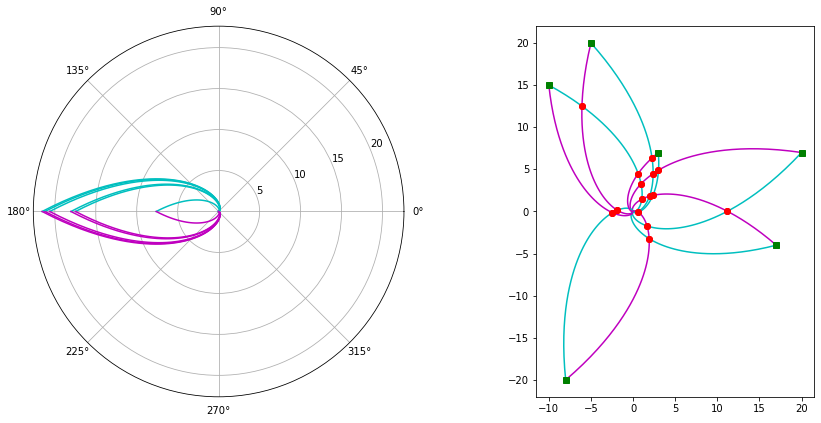

In [ ]:
#тест работы intersect и draw на большом наборе
b = 1.9
curves = []
crd_tuple = [ (17, -4), (20, 7), (-10, 15), (-5, 20), (-8, -20), (3,7) ]
for i in crd_tuple:
    curves.append(ShiftedLogCurve(b=b, root=(0,0), leaf=i, run=True))
draw(curves)
for i in curves:
    b = curves.copy()
    b.remove(i)
    for c in b:
        intersect(i, c, plotting=True)['position_type'][0]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

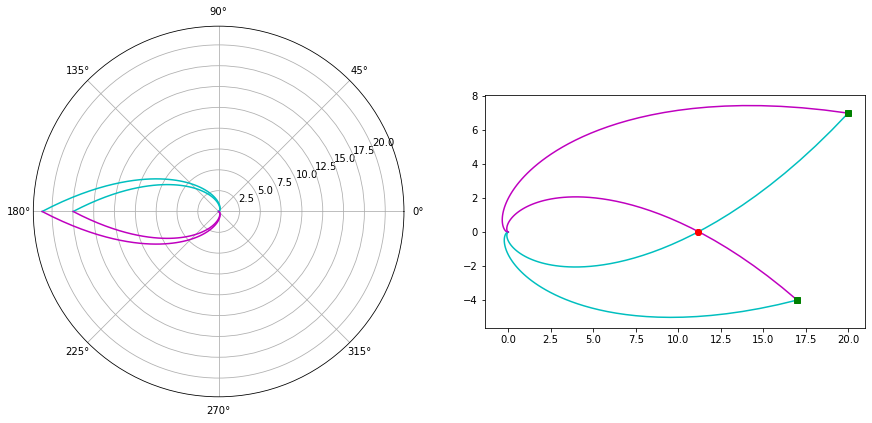

In [22]:
# тес работы intersect на двух кривых
b=1.9
curve = ShiftedLogCurve(b=b, root=(0,0), leaf=(17, -4), run=True)
curve1 = ShiftedLogCurve(b=b, root=(0,0), leaf=(20, 7), run=True)

# Пример отсутствия пересечений:
# curve = ShiftedLogCurve(b=b, root=(0,0), leaf=(-10, 15), run=True)
# curve1 = ShiftedLogCurve(b=b, root=(0,0), leaf=(-5, 5), run=True)

#th_use = np.linspace(0, 10, 100)
#curve.eval_a()
#curve.draw()
draw([curve1, curve])
intersect(curve, curve1, True)
assert i1 == i2
curve.a

0.14500123881377888

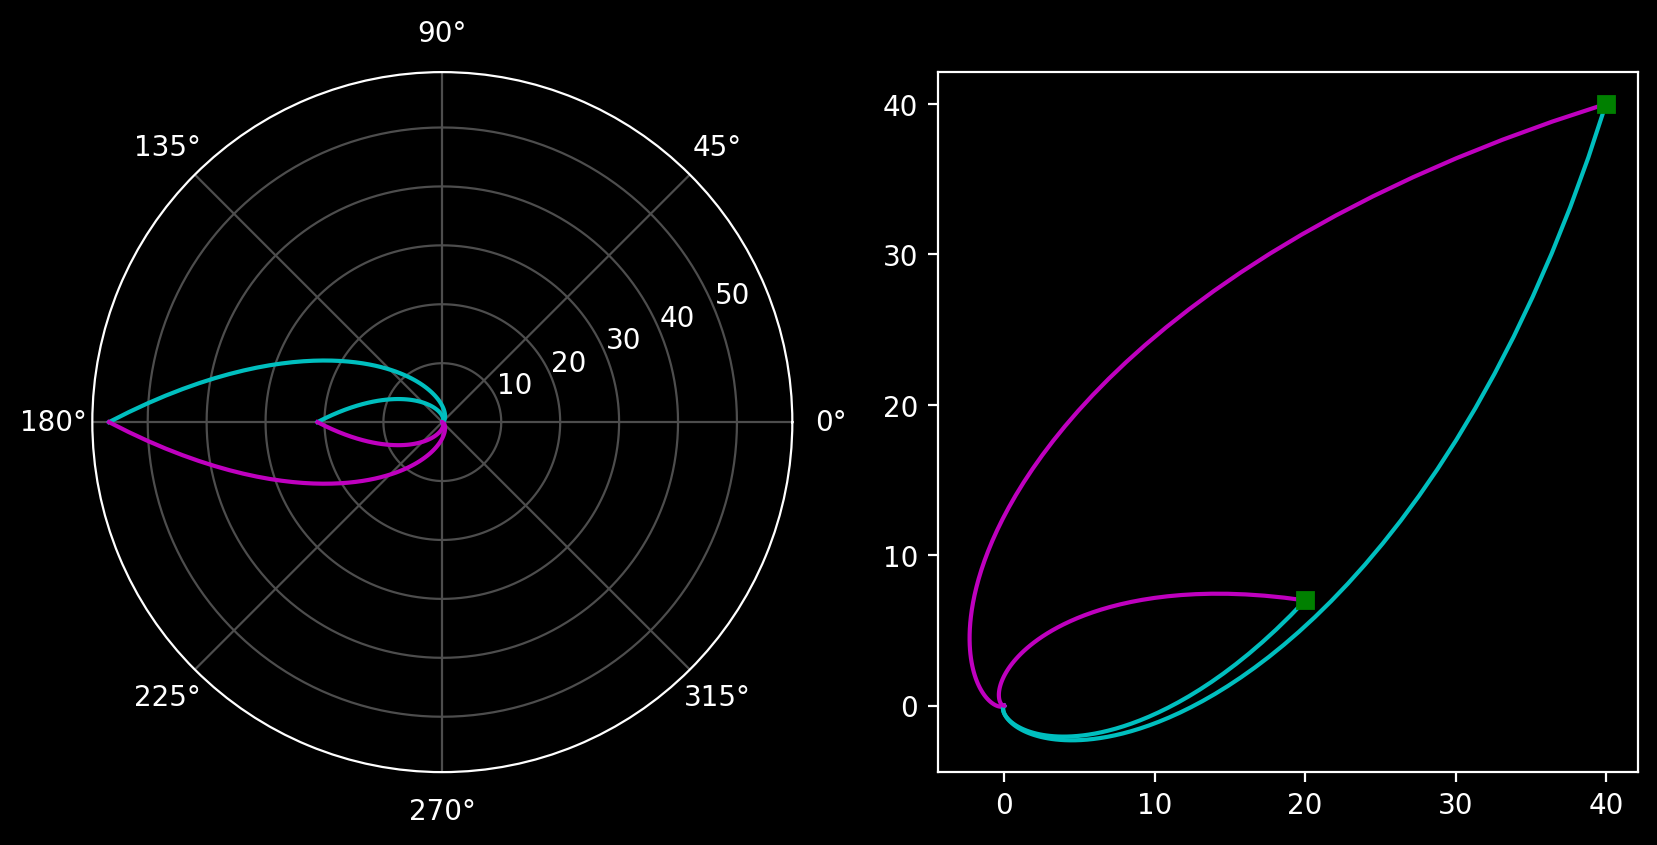

In [ ]:
# Пример плохого подбора параметра b. Не удалять!
b=1.9
curve = ShiftedLogCurve(b=b, root=(0,0), leaf=(40, 40))
curve1 = ShiftedLogCurve(b=b, root=(0,0), leaf=(20, 7))
th_use = np.linspace(0, 10, 100)
#curve.eval_a()
#curve.draw()
draw([curve, curve1])
curve.a

In [ ]:
curve.eval_r()

array([ 0.        ,  0.03640596,  0.07398573,  0.11277714,  0.15281928,
        0.19415246,  0.23681831,  0.2808598 ,  0.32632127,  0.37324853,
        0.42168881,  0.47169092,  0.5233052 ,  0.57658363,  0.63157988,
        0.68834932,  0.74694912,  0.80743831,  0.8698778 ,  0.93433047,
        1.00086124,  1.06953709,  1.1404272 ,  1.21360296,  1.28913807,
        1.36710858,  1.44759303,  1.53067247,  1.61643057,  1.70495369,
        1.79633098,  1.89065448,  1.98801916,  2.08852309,  2.19226747,
        2.2993568 ,  2.40989892,  2.52400515,  2.6417904 ,  2.76337331,
        2.8888763 ,  3.01842578,  3.15215221,  3.29019026,  3.43267896,
        3.57976179,  3.73158689,  3.88830715,  4.0500804 ,  4.21706957,
        4.38944283,  4.56737376,  4.75104157,  4.94063122,  5.13633364,
        5.33834592,  5.54687151,  5.76212041,  5.98430939,  6.21366222,
        6.45040987,  6.69479077,  6.94705102,  7.20744469,  7.476234  ,
        7.75368965,  8.04009106,  8.33572666,  8.64089418,  8.95

In [ ]:
class LogCurve_b(): 
    
    def __init__(self, alpha=60):
        self.r = np.linspace(0,10,100)
        self.alpha = np.radians(alpha)
        self.t = np.linspace(0, np.pi/np.tan(self.alpha), 100)
        self.phi = np.linspace(0, np.pi*2, 100) + np.tan(self.alpha)*self.t
        self.r = self.r*np.exp(-1*self.t)

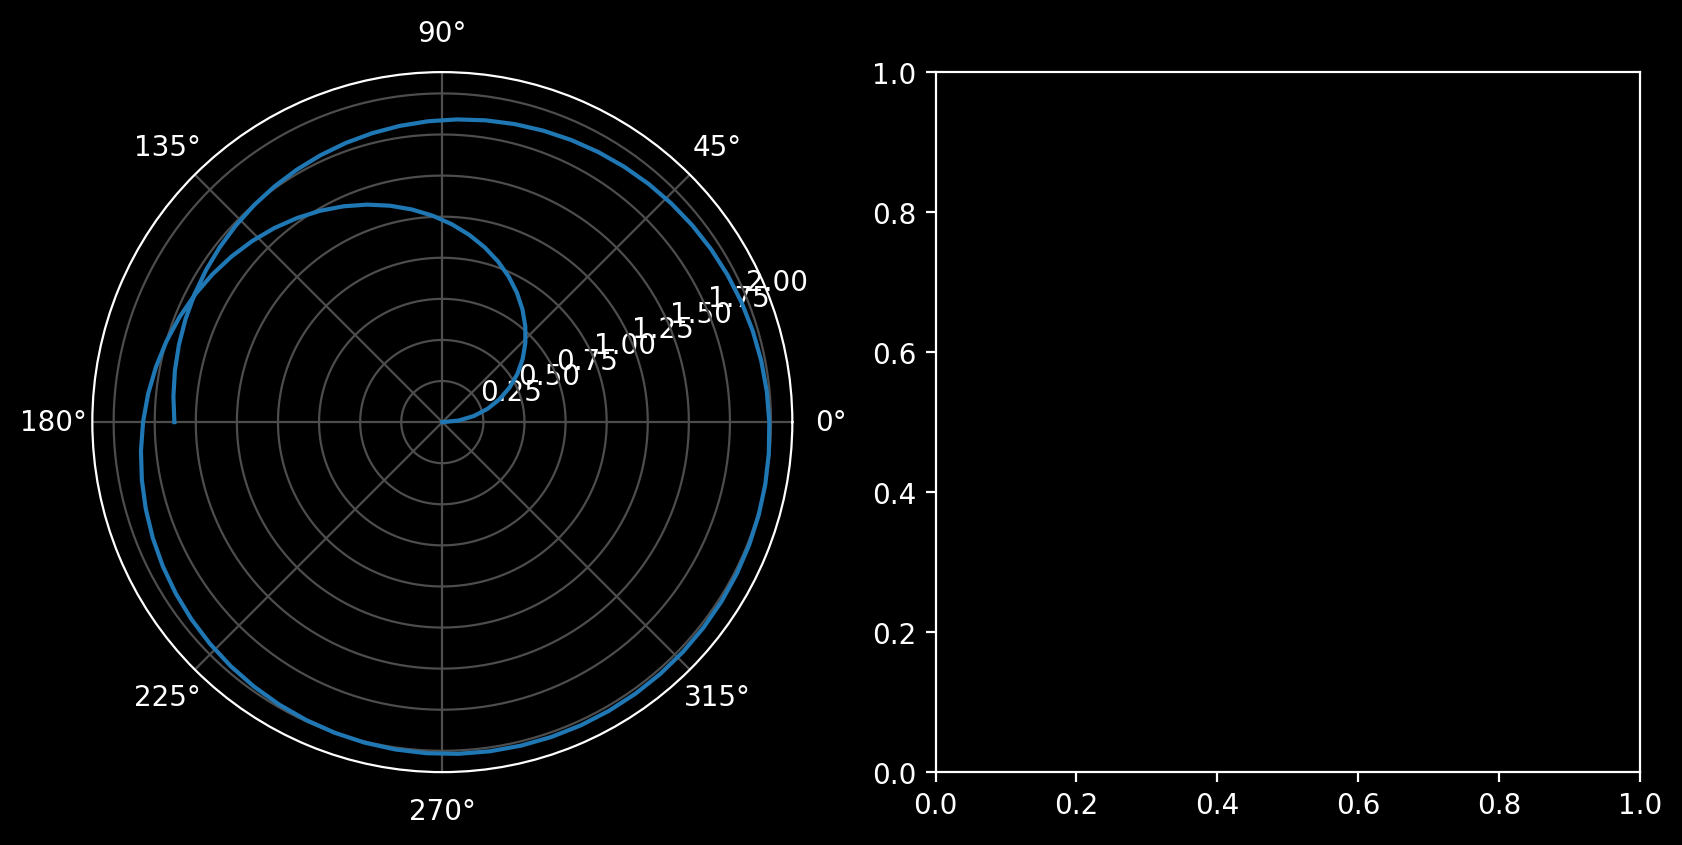

In [ ]:
curve = LogCurve_b(60)

#x = arr*np.cos(self.th)
#y = arr*np.sin(self.th)
fig = plt.figure(1,(10,10))
ax1 = fig.add_subplot(221,polar=True)
ax2 = fig.add_subplot(222,polar=False)
ax1.plot(curve.phi, curve.r)
#ax2.plot(x,y)
#ax2.set_aspect(1)